In [3]:
import torch
x_test = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_test.pt')
y_test = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/y_test.pt')

import sys 
sys.path.append("..") 

import io
import numpy as np
import pandas as pd
import neurokit2 as nk
#x_train = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_train.pt')
#y_train = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/y_train.pt')
import tqdm

stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}

#cnt_clean = np.zeros(4)

x_clean = torch.tensor([])
y_clean = torch.tensor([])
ind = torch.tensor([])
for i in tqdm.tqdm(range(y_test.shape[0])):
    try:
        if((x_test[i].var()<0.2) or (x_test[i].var()>5)):
            continue
        #ret = eng.DeBaseline_Wavelet(np.array(eng.mean5_3(x_train[i].tolist(),500,stdout=io.StringIO())[0]).tolist(),stdout=io.StringIO())
        ret = x_test[i]
        peaks,info = nk.ppg_peaks(pd.DataFrame(ret)[0],sampling_rate=int(64), show=False)
        _,info1 = nk.ppg_peaks(-pd.DataFrame(ret)[0],sampling_rate=int(64), show=False)
        
        dif = [ret[info['PPG_Peaks'][i]].tolist()-ret[info1['PPG_Peaks'][i]].tolist() for i in range(min(len(info1['PPG_Peaks']),len(info['PPG_Peaks'])))]
        if(np.sum(dif > 1.5*np.median(dif))>0):
            continue
        if((len(info['PPG_Peaks'])<20) or (len(info['PPG_Peaks'])>75)):
            continue
        ind=torch.cat((ind,torch.tensor([i])),axis=0)
    except:
        continue
y_clean = y_test[ind.long()]
x_clean = x_test[ind.long()]
torch.save(x_clean, '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_clean_noise_test.pt')
torch.save(y_clean, '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/y_clean_noise_test.pt')

 26%|███████████████████▊                                                       | 67423/254933 [05:58<09:31, 328.19it/s]/extern2/zgz/.conda/envs/wq/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/extern2/zgz/.conda/envs/wq/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|██████████████████████████▊                                                | 91200/254933 [08:00<10:52, 250.81it/s]/extern2/zgz/.conda/envs/wq/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/extern2/zgz/.conda/envs/wq/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 57%|██████████████████████████████████████████▋

In [4]:
torch.load("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/raw/x_800002.pt").shape

torch.Size([4826880])

In [12]:
import torch 
y_test = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/fea_32/x_801719.pt')

In [13]:
y_test[1,y_test[1,:]>200] = 0

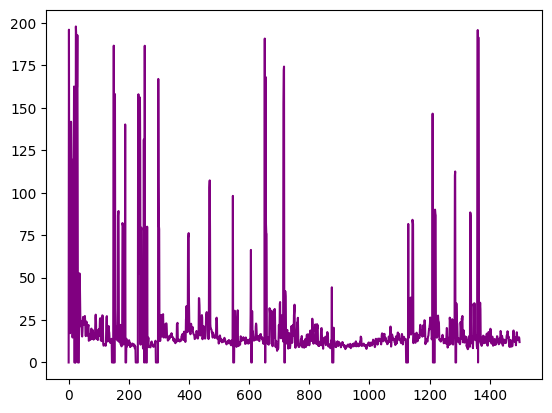

In [14]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(y_test[1,1000:2500].tolist(), color='purple' )#i
plt.show()

In [15]:
y_test[1,1000:2500].mean()

tensor(19.7300, dtype=torch.float64)

In [ ]:
/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/fea_32

In [6]:
import torch

from scipy import signal
from scipy import integrate

#new_x = signal.resample(x, 50)

import io
import numpy as np
import pandas as pd
import neurokit2 as nk
#x_train = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_train.pt')
#y_train = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/y_train.pt')
import tqdm
import hrvanalysis as hrvana
from concurrent import futures
import os

import sys

stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}

#cnt_clean = np.zeros(4)

import glob
from scipy.interpolate import interp1d

mode = 'cfs'

#all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/"+mode+"/raw/*.pt")])
hz = 128

nyquist_freq = hz/2  # 奈奎斯特频率
order = 8
cutoff_freq = 10  # Hz, 选择合适的截止频率
b, a = signal.butter(order, cutoff_freq / nyquist_freq, btype='lowpass', analog=False)
b_l, a_l = signal.butter(4, 0.5 / nyquist_freq, btype='lowpass', analog=False)


x = torch.load("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/raw/x_800002.pt")

mean = torch.mean(x)
std = torch.std(x)

# 标准化变量
std_x = (x - mean) / std
std_x = signal.filtfilt(b, a, std_x)

ppg_row = signal.resample(std_x, int(std_x.shape[0]/(hz/64)))

ppg_peaks_l = nk.ppg_findpeaks(-1 * std_x, sampling_rate=hz)
ppg_peaks_h = nk.ppg_findpeaks(std_x, sampling_rate=hz)

hr_x = list()
hr = list()
bl_x = list()
blood = list()

for i in range(len(ppg_peaks_l['PPG_Peaks']) - 1):
    #heart rate
    hr.append(ppg_peaks_l['PPG_Peaks'][i+1] - ppg_peaks_l['PPG_Peaks'][i])
    hr_x.append(ppg_peaks_l['PPG_Peaks'][i])

for i in range(len(ppg_peaks_h['PPG_Peaks']) - 1):
    blood.append(np.sum(-1*std_x[ppg_peaks_h['PPG_Peaks'][i]:ppg_peaks_h['PPG_Peaks'][i+1]]))
    bl_x.append(ppg_peaks_h['PPG_Peaks'][i])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [2]:
import torch
import pickle


with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/train_ref.pkl', 'rb') as f:
    temp = pickle.load(f)

In [12]:
import numpy as np
len(np.unique(list(temp.values())))

224

In [23]:
temp = {v: k for k, v in temp.items()}

In [35]:
len(temp)

224

In [ ]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/train_ref.pkl', 'rb') as f:
    temp = pickle.load(f)

In [15]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/train_sig.pkl', 'rb') as f:
    sig = pickle.load(f)

In [31]:
for i in temp:
    print(temp[i])
    break

800024


In [34]:
from tqdm import tqdm

mode = 'cfs' 

test_sigref = list()
test_fearef = list()

li = list()
for i in tqdm(temp):
    li.append(temp[i])
    test_sigref.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/sig_4/x_'+temp[i]+'.pt'))
    test_fearef.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/fea_32/x_'+temp[i]+'.pt'))
    

100%|█████████████████████████████████████████████████████████████████████████████████| 224/224 [00:15<00:00, 14.61it/s]


In [7]:
import os
import numpy as np

paid = np.unique([i[-9:-3] for i in os.listdir('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/sig_4')])

In [173]:
paid[0]

'800002'

In [189]:
import torch
from tqdm import tqdm

def adjust_length_1D(tensor, target_length = 1200 * 1024):
    current_length = tensor.size(0)

    if current_length < target_length:
        # 如果长度不足，补零
        padding = target_length - current_length
        adjusted_tensor = torch.nn.functional.pad(tensor, (0, padding))
    else:
        # 如果长度超过，截断
        adjusted_tensor = tensor[:target_length]

    return adjusted_tensor
def adjust_length_2D(tensor, target_length = 1200 * 1024):
    
    current_length = tensor.size(1)

    if current_length < target_length:
        # 如果长度不足，补零
        padding = target_length - current_length
        adjusted_tensor = torch.nn.functional.pad(tensor, (0, padding, 0, 0))
    else:
        # 如果长度超过，截断
        adjusted_tensor = tensor[:, :target_length]

    return adjusted_tensor

#label = list()
all_fea = list()
all_sig = list()

for i in tqdm(paid):
    
    sig_temp = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/sig_4/x_' + i + '.pt')
    sig_temp = (sig_temp - sig_temp.mean(1).unsqueeze(1))/sig_temp.std(1).unsqueeze(1)
    sig_temp = adjust_length_2D(sig_temp, 1200 * 60)
        
    fea_temp = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/fea_32/x_' + i + '.pt')
    fea_temp = (fea_temp - fea_temp.mean(1).unsqueeze(1))/fea_temp.std(1).unsqueeze(1)
    fea_temp = adjust_length_2D(fea_temp, 1199 * 3 + 1)
    
    all_sig.append(sig_temp.unsqueeze(0))
    all_fea.append(fea_temp.unsqueeze(0))

    #label.append( torch.tensor(test_label[test_label[:, 7] == i][:, 6].astype(float)) )

all_sig = torch.concat(all_sig, axis=0)
all_fea = torch.concat(all_fea, axis=0)

#torch.save(all_sig, '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all_sig.pt')
#torch.save(all_fea, '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all_fea.pt')



100%|█████████████████████████████████████████████████████████████████████████████████| 324/324 [00:03<00:00, 94.02it/s]


In [216]:
all_sig = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all_sig.pt')
all_fea = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all_fea.pt')

In [218]:
all_fea.shape

torch.Size([324, 32, 3598])

In [219]:
import pickle

label_li = list()

for i in tqdm(paid):
    label_temp = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/label/y_' + i + '.pt')
    
    label_li.append(label_temp.int().tolist())
    
#with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all_label.pkl', 'wb') as f:
#    pickle.dump(label_li, f)

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:01<00:00, 172.44it/s]


In [253]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/10h_input/test_all_label_frag.pkl', 'rb') as f:
    label = pickle.load(f)

In [74]:
np.unique(label_li[0])

array([0, 1, 2, 3, 5])

In [254]:
from operator import *
from tqdm import tqdm


stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}

label_index = label_li
li = list()

for j in tqdm(label):
    for i in range(len(label_index)):
        if i in li:
            continue
        temp1 = ''.join([str(k) for k in j])
        temp2 = ''.join([str(stage_reverse[k]) for k in label_index[i]])
        if temp1 in temp2:
            break
    li.append(i)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.94it/s]


In [255]:
len(np.unique(li))

100

In [180]:
temp = torch.load("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/raw/x_802717.pt")

In [181]:
temp.shape

torch.Size([4558080])

In [240]:
len(all_fea)

324

In [256]:
torch.save(all_sig[li], '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/10h_input/new/test_sig_conseq.pt')
torch.save(all_fea[li], '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/10h_input/new/test_fea_conseq.pt')

In [ ]:

torch.save(all_fea[li], '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/overall/new/train_fea_conseq_40.pt')

In [213]:
(all_sig[:10]==0).sum(axis=2)

tensor([[    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [ 1560,  1560,  1560,  1560],
        [ 2640,  2640,  2640,  2640],
        [    0,     0,     0,     0],
        [  420,   420,   420,   420],
        [ 2460,  2460,  2460,  2460],
        [ 4560,  4560,  4560,  4560],
        [ 6000,  6000,  6000,  6000],
        [12000, 12000, 12000, 12000]])

In [214]:
all_sig.shape

torch.Size([324, 4, 72000])

In [169]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/overall/new/test_all_label_44.pkl', 'wb') as f:
    pickle.dump([label_index[i] for i in li] ,f)

In [172]:
stage_reverse[]

TypeError: unhashable type: 'list'

In [170]:
np.unique(label_index[0] )

array([0, 1, 2, 3, 5])

In [104]:
sig = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/overall/new/train_sig_conseq_40.pt')

In [146]:
all_fea[li][0][0]

tensor([-0.0902, -0.0872, -0.0893,  ..., -0.0748, -0.0726, -0.0732],
       dtype=torch.float64)

In [91]:
all_sig[li].shape

torch.Size([44, 4, 72000])

In [120]:
sig[0][0].tolist()[:2000]

[-0.07969115637994842,
 -0.0818248365092026,
 -0.08395851663845676,
 -0.08609219676771092,
 -0.08822587689696507,
 -0.08947062466555128,
 -0.09049139865970661,
 -0.09249118964867381,
 -0.0940058828234856,
 -0.0947120796413717,
 -0.09399434693796613,
 -0.09318382559016504,
 -0.09318382559016504,
 -0.09249547841611337,
 -0.09144844149014092,
 -0.09042950036719098,
 -0.08928319160387228,
 -0.08796234200004827,
 -0.0857407791061166,
 -0.08319342629874173,
 -0.0852014567539302,
 -0.0870197390125848,
 -0.08670413777981271,
 -0.08542166171769272,
 -0.08229333370863587,
 -0.0809246902046735,
 -0.0809246902046735,
 -0.0809246902046735,
 -0.0809246902046735,
 -0.0809246902046735,
 -0.0809246902046735,
 -0.08308172282382156,
 -0.085957766316019,
 -0.08776790772448537,
 -0.08932408947004573,
 -0.09063282118759612,
 -0.09173501868097059,
 -0.09241431276293723,
 -0.09310267509114369,
 -0.09379623064317565,
 -0.09450242746106176,
 -0.09539587343520553,
 -0.09647656856560699,
 -0.09546499993036305,
 -

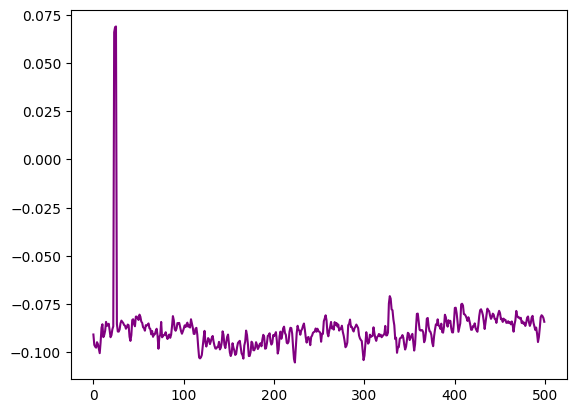

In [207]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(all_fea[4][0].tolist()[:500], color='purple' )#i
plt.show()

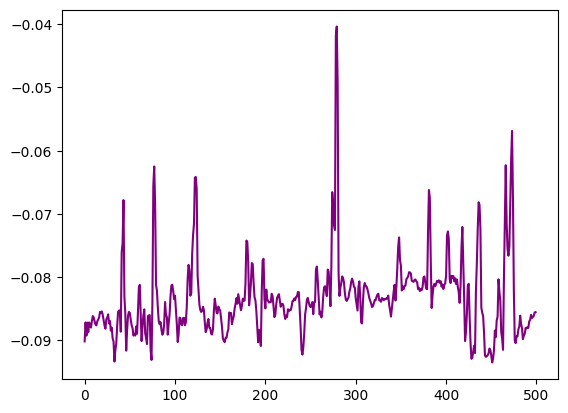

In [151]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(all_fea[li][0][0][:500], color='purple' )#i
plt.show()


In [128]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/overall/train_sig_conseq_40.pkl', 'rb') as f:
    sig_temp = pickle.load(f)

In [138]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/overall/train_fea_conseq_40.pkl', 'rb') as f:
    fea_temp = pickle.load(f)

In [143]:
fea.shape

torch.Size([32, 3769])

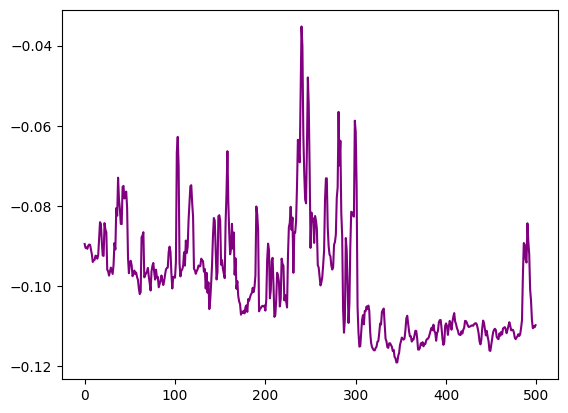

In [152]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(fea_temp[0][0][:500], color='purple' )#i
plt.show()


In [140]:
fea_temp[0]

tensor([[-0.0895, -0.0905, -0.0904,  ..., -0.0820, -0.0806, -0.0815],
        [-0.0444, -0.0660, -0.0657,  ..., -0.0793, -0.0809, -0.0817],
        [ 0.0874, -0.0133, -0.0127,  ..., -0.0884, -0.0891, -0.0996],
        ...,
        [-0.1238, -0.1238, -0.1238,  ..., -0.1024, -0.1140, -0.1236],
        [    nan,     nan,     nan,  ..., -0.0784, -0.0774, -0.0780],
        [-0.1102, -0.1102, -0.1102,  ..., -0.0921, -0.1012, -0.1100]],
       dtype=torch.float64)

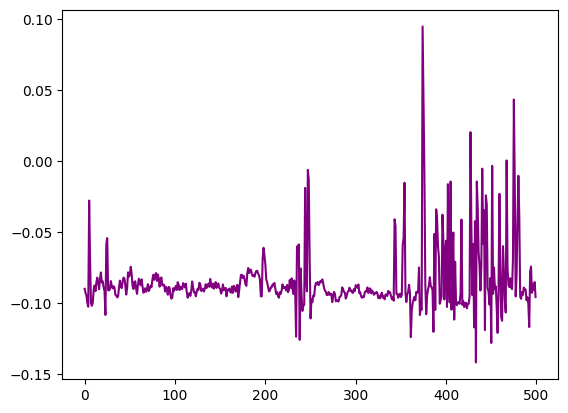

In [130]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(sig_temp[0][0].tolist()[:500], color='purple' )#i
plt.show()

In [ ]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/train_sig.pkl', 'rb') as f:
    sig = pickle.load(f)

with open('mesa/'+mode+'_label.pkl', 'wb') as f:
    pickle.dump(test_label, f)

In [47]:
all_sig.shape

torch.Size([324, 4, 72000])

In [48]:
all_fea.shape

torch.Size([324, 32, 3598])

In [44]:
torch.concat([fea.unsqueeze(0), fea.unsqueeze(0)], axis=0).shape

torch.Size([2, 32, 3769])

In [2]:
import torch
x_test = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_test.pt')

FileNotFoundError: [Errno 2] No such file or directory: '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_test.pt'

In [2]:
import torch
class_counts = torch.tensor([4, 10, 1.5, 2.6])
total_samples = class_counts.sum()
weights = total_samples / class_counts  # 计算权重
weights = weights / weights.sum() 

In [3]:
weights

tensor([0.1784, 0.0714, 0.4758, 0.2745])

In [60]:
y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/raw/y_0910.pt')

In [2]:
import pickle 
with open('mesa/train_ahi_label.pkl', 'rb') as f:
    temp = pickle.load(f)

In [53]:
temp1.shape

(1670999, 8)

In [58]:
temp1.shape

(1670999, 8)

In [62]:
np.zeros([len(temp1),1]).shape

(1670999, 1)

In [80]:
np.zeros(10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [115]:
with open('mesa/test_exc_label.pkl', 'rb') as f:
    temp1 = pickle.load(f)

In [116]:
temp2 = np.c_[temp1, np.zeros([len(temp1),1], dtype=int)]

In [122]:
cnt = 0
fir = {'0':0, '1':0, '2':0, '3':0}
sec = {'0':0, '1':0, '2':0, '3':0}
for i in range(temp1.shape[0]-1):
    if((temp2[i,7] == temp2[i+1,7]) and (temp2[i,6] != temp2[i+1,6])):
        cnt+=1
        temp2[i, 8] = 1
        temp2[i+1, 8] = 1
        
        temp2[i-1, 8] = 1
        temp2[i+2, 8] = 1

        
        temp2[i-2, 8] = 1
        temp2[i+3, 8] = 1
cnt

3154

In [117]:
temp1.shape

(140739, 8)

In [124]:
np.sum(temp2[:,-1].astype(int))

17933

In [108]:
len(temp2)

1277075

In [96]:
temp2.shape

(181924, 9)

In [55]:
fir

{'0': 73127, '1': 105300, '2': 34125, '3': 20962}

In [56]:
sec

{'0': 72978, '1': 105135, '2': 34136, '3': 21265}

In [15]:
['0', '19200', '0001'] in temp[:,[0,1,-1]]

True

In [20]:
import pandas as pd

# 创建两个示例数据集
df1 = pd.DataFrame(temp)
df2 = pd.DataFrame(temp1)


In [27]:
merged_df = pd.merge(df1, df2, on=[0,1,2,3,4,5,7], how='inner')

In [40]:
np.array(merged_df).shape

(1667180, 9)

In [36]:
np.unique(merged_df.iloc[:, 6])

array(['0', '1'], dtype=object)

In [31]:
import numpy as np
np.unique(merged_df.iloc[:,6])

array(['0', '1'], dtype=object)

In [74]:
np.count(np.array(resu)[:,-2])

AttributeError: module 'numpy' has no attribute 'count'

In [76]:
count_elements = {}

for item in np.array(resu)[:,-2]:
    if item in count_elements:
        count_elements[item] += 1
    else:
        count_elements[item] = 1

print(count_elements)
# Output: {1: 2, 2: 2, 3: 2, 4: 1}

print(list(count_elements.keys()))
# Output: [1, 2, 3, 4]

print(list(count_elements.values()))

{'1': 40616, '0': 141308}
['1', '0']
[40616, 141308]


In [79]:
import os
label = os.listdir('data/mesa/polysomnography/annotations-events-profusion/')

In [88]:
import re
import numpy as np

resu = np.unique([re.findall(r'\d+', i)[0] for i in label])

In [93]:
already = np.unique([i[-7:-3] for i in os.listdir("../train/fea_32/")])
#test_label = list()

#for i in tqdm.tqdm(already):

In [103]:
count = 0
for i in np.intersect1d(resu, already):
    if i in already:
        count +=1

In [94]:
count = 0
for i in already :
    if i in resu:
        count += 1

In [96]:
len(already)

1854

In [95]:
count

1850

In [48]:
from label_ahi import getLabels
xml_file = 'data/mesa/polysomnography/annotations-events-profusion/mesa-sleep-0910-profusion.xml'

In [58]:
ahi = getLabels(xml_file)

SpO2 artifact
SpO2 artifact
SpO2 artifact
Limb Movement (Left)
Limb Movement (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
Limb Movement (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
PLM (Left)
Limb Movement (Left)
Limb Movement (Left)
Limb Movement (Left)
SpO2 artifact


In [64]:
if(np.any(ahi['ahi_labels'][y[10,1]:y[10,1]+30])):
    print(1)
else:
    print(0)

0


In [15]:
import os
import numpy as np
mode = 'test'
already = np.unique([i[-7:-3] for i in os.listdir("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/"+mode+"/"+mode+"_fea/")])

In [99]:
from scipy import signal

nyquist_freq = 128  # 奈奎斯特频率
order = 8
cutoff_freq = 10  # Hz, 选择合适的截止频率
b, a = signal.butter(order, cutoff_freq / nyquist_freq, btype='low', analog=False)
b_l, a_l = signal.butter(4, 0.5 / nyquist_freq, btype='lowpass', analog=False)

In [174]:
import sys
sys.path.append('../..')

In [180]:
import pyedflib as pyedflib
from source.mesa.mesa_psg_service import MesaPSGService

file_id = '6781'
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/sleep/sleep_classifiers' +
                              '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
raw_labeled_sleep = MesaPSGService.load_raw(file_id)
signal_labels = edf_file.getSignalLabels()
ppg = edf_file.readSignal(signal_labels.index('Pleth'))
y = list()
x = list()
freq = int(edf_file.getSampleFrequencies()[signal_labels.index('Pleth')])
edf_file.close()

In [219]:
stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}
raw_labeled_sleep = MesaPSGService.load_raw(file_id)
raw_labeled_sleep = torch.tensor(raw_labeled_sleep)
raw_labeled_sleep[:, 0] = torch.tensor([stage_reverse[i.tolist()] for i in raw_labeled_sleep[:,0]])
raw_labeled_sleep[:, 1] = raw_labeled_sleep[:, 1] / 30
raw_labeled_sleep[:, 2] = raw_labeled_sleep[:, 2] / 30

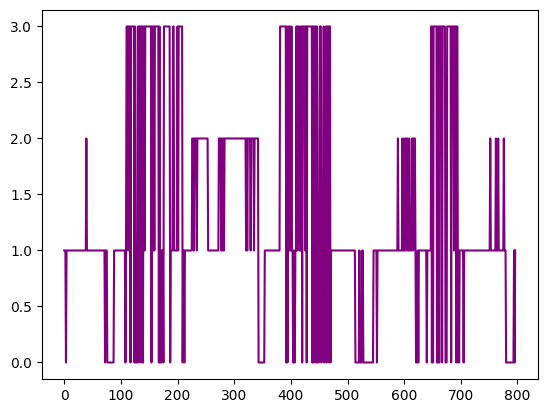

In [325]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot([stage_reverse[i.tolist()] for i in te[:, 0]], color='purple' )#i
plt.show()

In [531]:
te = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/raw/y_0081.pt')

In [533]:
te[-10:]

tensor([[    0, 31800,    81],
        [    0, 31830,    81],
        [    0, 31860,    81],
        [    0, 31890,    81],
        [    0, 31920,    81],
        [    0, 31950,    81],
        [    0, 31980,    81],
        [    1, 32010,    81],
        [    0, 32040,    81],
        [    1, 32070,    81]])

In [495]:
label = [stage_reverse[i.tolist()] for i in te[:, 0]]

In [496]:
co_list = list()
for i in range(len(label)-9):
    temp = list()
    temp.append(label[i:i+10].count(0))
    temp.append(label[i:i+10].count(1))
    temp.append(label[i:i+10].count(2))
    temp.append(label[i:i+10].count(3))
    co_list.append(temp)
co_list = np.array(co_list)

In [497]:
beg_list = list()
for i in range(len(label)-9):
    beg_item = list()
    beg_item.append(i * 30 * 64)
    beg_item.append((i+10) * 30 * 64)
    beg_item.append(i * 30)
    beg_item.append((i+10) * 30)
    beg_item.append(3 * i)
    beg_item.append(3 * (i+10)-2)
    beg_item.append(co_list[i].argmax())
    
    beg_list.append(beg_item)
beg_list = np.array(beg_list)

In [26]:
import torch
label = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/raw/y_2400.pt')

In [2]:
import os
paid = [i[-7:-3] for i in os.listdir('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/mesa/label')]

In [28]:
sig = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/sig_4/x_2400.pt')

array(['0001', '0002', '0006', ..., '6810', '6811', '6812'], dtype='<U4')

In [11]:
import numpy as np

index = dict()
for i in range(4):
    index[i] = list()
for i in range(len(test_label)):
    index[int(test_label[i, 6])].append(test_label[i])
length = len(index[0])
for i in range(1,4):
    index[i] = np.array(index[i])
    length = min(length, len(index[i]))

In [22]:
test_ref[index[2][1000][-1]]

18

In [24]:
test_ppg[test_ref[index[2][1000][-1]]][int(index[2][1000][0]): int(index[2][1000][1])].float()

tensor([ 0.0892,  0.0991,  0.1128,  ..., -0.2869, -0.2236, -0.1637])

In [345]:
ref = test_ref[index[1][100][-1]]

In [350]:
fea = test_fea[ref][:, int(index[1][100][4]): int(index[1][100][5])]

In [394]:
fea[22]

tensor([0.3685, 0.3922, 0.4891,    nan, 0.4392, 0.4852, 0.4443,    nan,    nan,
           nan, 0.4323,    nan,    nan, 0.4460,    nan,    nan,    nan, 0.6633,
           nan,    nan, 0.4392, 0.2980, 0.1057, 0.1347,    nan, 0.3407,    nan,
           nan], dtype=torch.float64)

In [387]:
((fea - test_std[0][ref][:,0:1])/test_std[0][ref][:,1:2]).shape

torch.Size([32, 28])

In [395]:
delete_indices = [30, 22]
features = fea.index_select(dim=0, index=torch.tensor(delete_indices))

In [399]:
mask = torch.ones(32, dtype=torch.bool)
mask[[22, 30]] = False
features = fea[mask]

In [402]:
features

tensor([[ 9.8129e+02,  1.0109e+03,  1.0842e+03,  1.0820e+03,  1.1981e+03,
          1.2151e+03,  1.2256e+03,  1.1373e+03,  1.0874e+03,  1.1137e+03,
          1.0844e+03,  1.0902e+03,  1.0581e+03,  1.0540e+03,  1.0627e+03,
          1.0807e+03,  1.0980e+03,  1.1319e+03,  1.1253e+03,  1.0769e+03,
          1.0851e+03,  1.1091e+03,  1.1782e+03,  1.1632e+03,  1.1574e+03,
          1.1061e+03,  1.1181e+03,  1.1121e+03],
        [ 1.4162e+02,  1.5437e+02,  1.4417e+02,  1.7153e+02,  5.7628e+02,
          5.7021e+02,  5.5321e+02,  1.8192e+02,  1.9391e+02,  2.0438e+02,
          1.4109e+02,  1.3209e+02,  1.0968e+02,  1.0694e+02,  1.0927e+02,
          1.2023e+02,  1.1160e+02,  1.2678e+02,  1.3759e+02,  1.2908e+02,
          1.3015e+02,  1.2936e+02,  1.9652e+02,  2.0489e+02,  2.1084e+02,
          1.2755e+02,  1.4804e+02,  1.3254e+02],
        [ 1.4162e+02,  1.4136e+02,  1.5807e+02,  1.8376e+02,  5.8339e+02,
          5.8025e+02,  2.4602e+02,  1.6480e+02,  1.6591e+02,  1.7897e+02,
          1.21

In [388]:
test_std[1][ref][:,0:1].shape

torch.Size([4, 1])

In [389]:
test_std[2][ref][0:1].shape

torch.Size([1])

In [374]:
test_std[0][ref][:,0].shape

torch.Size([32])

In [371]:
torch.concat([(fea[i] - test_std[0][ref][i][0])/test_std[0][ref][i][1] for i in range(len(fea))]).shape

torch.Size([896])

In [332]:
test_std = [std_fea, std_sig, std_ppg]

In [362]:
test_std[0][ref].shape

torch.Size([32, 2])

In [589]:
import os
import tqdm
import pickle

mode = 'train'
stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}
already = np.unique([i[-7:-3] for i in os.listdir("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/"+mode+"/fea_32/")])
test_ref = dict(zip(already, np.array(range(len(already)))))
test_fearef = list()
test_sigref = list()
test_ppgref = list()
test_label = list()

for i in tqdm.tqdm(already):
    
    test_fearef.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+mode+'/fea_32/x_'+i+'.pt'))
    test_sigref.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+mode+'/sig_4/x_'+i+'.pt'))
    test_ppgref.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+mode+'/ppg/x_'+i+'.pt'))
    
    y_raw = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+mode+'/raw/y_'+i+'.pt')
    label = y_raw[:, 0].tolist()
    label = [stage_reverse[j] for j in label]

    
    count_list = list()
    for j in range(len(label)-9):
        temp = list()
        temp.append(label[j:j+10].count(0))
        temp.append(label[j:j+10].count(1))
        temp.append(label[j:j+10].count(2))
        temp.append(label[j:j+10].count(3))
        count_list.append(temp)
    count_list = np.array(count_list)

    beg_list = list()
    for j in range(len(label)-9):
        beg_item = list()
        beg_item.append(j * 30 * 64)
        beg_item.append((j+10) * 30 * 64)
        beg_item.append(j * 30)
        beg_item.append((j+10) * 30)
        beg_item.append(3 * j)
        beg_item.append(3 * (j+10)-2)
        beg_item.append(count_list[j].argmax())
        beg_item.append(i)
        
        beg_list.append(beg_item)

    test_label.append(np.array(beg_list)[count_list.max(1)>=8])
test_label = np.concatenate(test_label, axis = 0)

'''
ref  :  mode_ref  id:index
label:  mode_label
ppg  :  test_ppgref[ind][int(test_label[i, 0]) : int(test_label[i, 1])].shape[0])
sig  :  test_sigref[ind][:,int(test_label[i, 2]) : int(test_label[i, 3])].shape[1])
fea  :  test_fearef[ind][:,int(test_label[i, 4]) : int(test_label[i, 5])].shape[1])

ind = test_ref[test_label[i, 7]]
ground_truth = test_ref[test_label[i, 6]]
'''

with open('mesa/'+mode+'_fea.pkl', 'wb') as f:
    pickle.dump(test_fearef, f)
with open('mesa/'+mode+'_sig.pkl', 'wb') as f:
    pickle.dump(test_sigref, f)
with open('mesa/'+mode+'_ppg.pkl', 'wb') as f:
    pickle.dump(test_ppgref, f)
with open('mesa/'+mode+'_ref.pkl', 'wb') as f:
    pickle.dump(test_ref, f)
with open('mesa/'+mode+'_label.pkl', 'wb') as f:
    pickle.dump(test_label, f)
'''with open('mesa/test_fea.pkl', 'rb') as f:
    test_fearef = pickle.load(f)'''

 11%|███████████████▊                                                                                                                              | 206/1854 [01:36<12:49,  2.14it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/sig_4/x_0692.pt'

In [42]:
self.ppg = torch.tensor(ppg).float()
self.ppg = (self.ppg - torch.mean(self.ppg))/torch.std(self.ppg)
self.ppg = torch.nan_to_num(self.ppg, nan=0.0)

(2, 8)

In [255]:
from tqdm import tqdm
import pickle

mode = 'test'
with open('mesa/'+mode+'_fea.pkl', 'rb') as f:
    test_fea = pickle.load(f)
with open('mesa/'+mode+'_sig.pkl', 'rb') as f:
    test_sig = pickle.load(f)
with open('mesa/'+mode+'_ppg.pkl', 'rb') as f:
    test_ppg = pickle.load(f)
with open('mesa/'+mode+'_ref.pkl', 'rb') as f:
    test_ref = pickle.load(f)
with open('mesa/'+mode+'_label.pkl', 'rb') as f:
    test_label = pickle.load(f)

std_fea = list()
for i in tqdm(range(len(test_fea))):
    temp_peo = list()
    for j in range(test_fea[i].shape[0]):
        temp_peo.append(torch.tensor([[test_fea[i][j][~test_fea[i][j].isnan()].mean(), 
                                      test_fea[i][j][~test_fea[i][j].isnan()].std()]]))
    temp_peo = torch.concat(temp_peo,axis=0).unsqueeze(0)
    std_fea.append(torch.tensor(temp_peo))
std_fea = torch.concat(std_fea)

std_sig = list()
for i in tqdm(range(len(test_sig))):
    temp_peo = list()
    for j in range(test_sig[i].shape[0]):
        temp_peo.append(torch.tensor([[test_sig[i][j][~test_sig[i][j].isnan()].mean(), 
                                      test_sig[i][j][~test_sig[i][j].isnan()].std()]]))
    temp_peo = torch.concat(temp_peo,axis=0).unsqueeze(0)
    std_sig.append(torch.tensor(temp_peo))
std_sig = torch.concat(std_sig)

std_ppg = list()
for i in tqdm(range(len(test_ppg))):
    std_ppg.append(torch.tensor([[test_ppg[i][~test_ppg[i].isnan()].mean(), 
                                  test_ppg[i][~test_ppg[i].isnan()].std()]]))
std_ppg = torch.concat(std_ppg)

with open('mesa/'+mode+'_std.pkl', 'wb') as f:
    pickle.dump([std_fea, std_sig, std_ppg], f)

  0%|                                                                                           | 0/201 [00:00<?, ?it/s]/tmp/ipykernel_377620/4072460619.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_fea.append(torch.tensor(temp_peo))
  0%|                                                                                           | 0/201 [00:00<?, ?it/s]/tmp/ipykernel_377620/4072460619.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_sig.append(torch.tensor(temp_peo))
100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 210.15it/s]


In [1]:
import pickle

mode = 'test'
with open('mesa/'+mode+'_fea.pkl', 'rb') as f:
    test_fea = pickle.load(f)
with open('mesa/'+mode+'_sig.pkl', 'rb') as f:
    test_sig = pickle.load(f)
with open('mesa/'+mode+'_ppg.pkl', 'rb') as f:
    test_ppg = pickle.load(f)
with open('mesa/'+mode+'_ref.pkl', 'rb') as f:
    test_ref = pickle.load(f)
with open('mesa/'+mode+'_label.pkl', 'rb') as f:
    test_label = pickle.load(f)

In [8]:
test_ppg[test_ref[test_label[100][7]]]

tensor([-0.4288,  1.1928,  0.8106,  ..., -2.1403, -2.0777, -2.7289],
       dtype=torch.float64)

In [9]:
test_ppg[test_ref[test_label[100][7]]][int(test_label[100][0]):int(test_label[100][1])]

tensor([0.3226, 0.3128, 0.2351,  ..., 0.5884, 0.6215, 0.6486],
       dtype=torch.float64)

In [264]:
std_fea.shape, std_sig.shape, std_ppg.shape

(torch.Size([201, 32, 2]), torch.Size([201, 4, 2]), torch.Size([201, 2]))

In [127]:
temp.shape

torch.Size([5061867])

In [154]:
temp[~temp.isnan()].shape

torch.Size([2237380])

In [114]:
temp = list()
for j in range(len(test_fea)):
    temp.append(test_fea[j][6])
temp = torch.cat(temp, axis = 0)

In [ ]:
for i in range(test_fea[0].shape[0]):
    temp = list()
    for j in range(len(test_fea)):
        temp.append(test_fea[j][i])
    temp = torch.cat(temp, axis = 0)

    if(!torch.isnan(temp).any()):
        for j in range(len(test_fea)):
            test_fea[j][i] = (test_fea[j][i] - torch.mean(temp))/torch.std(temp)
    else:
        print(i)

with open('mesa/'+mode+'_sig.pkl', 'wb') as f:
    pickle.dump(test_sig, f)

In [46]:
'''
self.mode = mode
with open('mesa/'+mode+'_fea.pkl', 'rb') as f:
    test_fea = pickle.load(f)
with open('mesa/'+mode+'_sig.pkl', 'rb') as f:
    test_sig = pickle.load(f)
with open('mesa/'+mode+'_ppg.pkl', 'rb') as f:
    test_ppg = pickle.load(f)
with open('mesa/'+mode+'_ref.pkl', 'rb') as f:
    test_ref = pickle.load(f)
with open('mesa/'+mode+'_label.pkl', 'rb') as f:
    test_label = pickle.load(f)
'''
'''
self.ppg = torch.tensor(ppg).float()
self.ppg = (self.ppg - torch.mean(self.ppg))/torch.std(self.ppg)
self.ppg = torch.nan_to_num(self.ppg, nan=0.0)

self.label = torch.tensor(label)
'''
index = dict()
length = 0
for i in range(4):
    index[i] = list()
    
for i in range(len(test_label)):
    index[int(test_label[i, 6])].append(test_label[i])
for i in range(4):
    index[i] = np.array(index[i])
    length = min(length, len(index[i]))

self.index = index

self.len = 8 * length#label.shape[0]

In [54]:
test_label.shape

(140739, 8)

In [59]:
index[3].shape, index[2].shape, index[1].shape, index[0].shape

((21379, 8), (9255, 8), (83789, 8), (26316, 8))

In [58]:
index[0].shape

(26316, 8)

In [575]:
ind = test_ref[test_label[0,7]]

In [583]:
ppg_len = list()
sig_len = list()
fea_len = list()
for i in range(test_label.shape[0]):
    ind = test_ref[test_label[i, 7]]
    ppg_len.append(test_ppgref[ind][int(test_label[i, 0]) : int(test_label[i, 1])].shape[0])
    sig_len.append(test_sigref[ind][:,int(test_label[i, 2]) : int(test_label[i, 3])].shape[1])
    fea_len.append(test_fearef[ind][:,int(test_label[i, 4]) : int(test_label[i, 5])].shape[1])

In [562]:
with open('mesa/test_fea.pkl', 'rb') as f:
    test_fearef = pickle.load(f)

In [558]:
test_fearef[10].shape

torch.Size([32, 3601])

In [554]:
test_label

array([['0', '19200', '0', ..., '28', '1', '0081'],
       ['1920', '21120', '30', ..., '31', '1', '0081'],
       ['3840', '23040', '60', ..., '34', '1', '0081'],
       ...,
       ['1870080', '1889280', '29220', ..., '2950', '1', '6807'],
       ['1872000', '1891200', '29250', ..., '2953', '1', '6807'],
       ['1873920', '1893120', '29280', ..., '2956', '1', '6807']],
      dtype='<U21')

In [552]:
np.concatenate(test_label, axis = 0)

array([['0', '19200', '0', ..., '28', '1', '0081'],
       ['1920', '21120', '30', ..., '31', '1', '0081'],
       ['3840', '23040', '60', ..., '34', '1', '0081'],
       ...,
       ['1870080', '1889280', '29220', ..., '2950', '1', '6807'],
       ['1872000', '1891200', '29250', ..., '2953', '1', '6807'],
       ['1873920', '1893120', '29280', ..., '2956', '1', '6807']],
      dtype='<U21')

In [522]:
np.array(range(len(already)))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [509]:
te = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/fea_32/x_6036.pt')

In [507]:
te[beg_list[-1,0]:beg_list[-1,1]].shape

torch.Size([19200])

In [512]:
te.shape

torch.Size([32, 3067])

In [462]:
np.fft.rfft(te[0, 20000:20030]).shape

(16,)

In [430]:
clean_rri = te[2,-30:]*1000

In [390]:
torch.isnan(te[:,:]).any(axis=1)

NameError: name 'te' is not defined

In [428]:
clean_rri = hrvana.remove_outliers(rr_intervals=te[2,-30:]*1000, low_rri=300, high_rri=2000, verbose=False)

In [413]:
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")

In [415]:
clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik", verbose=False)

In [417]:
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri)

In [419]:
clean_rri = np.array(clean_rri)[[k == k for k in clean_rri]].tolist()

In [435]:
temp = hrvana.get_frequency_domain_features(clean_rri)

{'lf': 6363.370765663881,
 'hf': 14488.031653966871,
 'lf_hf_ratio': 0.4392156862745098,
 'lfnu': 30.517711171662125,
 'hfnu': 69.48228882833789,
 'total_power': 22896.771594308426,
 'vlf': 2045.3691746776753}

In [364]:
te = torch.load("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/raw/y_0081.pt")

In [399]:
import hrvanalysis as hrvana


In [489]:
te[:,-30:]

tensor([[ 8.6575e+02,  8.6225e+02,  8.6255e+02,  8.6747e+02,  8.6599e+02,
          8.8240e+02,  8.7351e+02,  8.7849e+02,  8.6574e+02,  8.6599e+02,
          8.7695e+02,  8.7442e+02,  8.8524e+02,  8.7214e+02,  8.7120e+02,
          8.6910e+02,  8.6494e+02,  8.7417e+02,  8.6720e+02,  1.3709e+03,
          1.3564e+03,  1.5743e+03,  1.3471e+03,  1.3365e+03,  1.2071e+03,
          1.4513e+03,  1.4703e+03,  1.3713e+03,  9.2441e+02,  9.1211e+02],
        [ 2.3535e+01,  2.2483e+01,  2.4231e+01,  2.7294e+01,  2.6923e+01,
          3.0016e+01,  3.3771e+01,  3.1287e+01,  2.1655e+01,  2.3393e+01,
          3.5957e+01,  5.3195e+01,  4.9327e+01,  4.3604e+01,  2.1162e+01,
          2.6894e+01,  2.7544e+01,  3.1121e+01,  2.5066e+01,  1.2027e+03,
          1.2091e+03,  1.4129e+03,  1.0877e+03,  1.0958e+03,  7.9542e+02,
          1.1761e+03,  1.1626e+03,  1.1569e+03,  2.2118e+02,  2.2535e+02],
        [ 2.0858e+01,  1.9758e+01,  2.0270e+01,  2.1739e+01,  2.1349e+01,
          2.3462e+01,  2.5080e+01,  

In [318]:
ppg_peaks_h = nk.ppg_findpeaks(std_x, sampling_rate=256)

In [319]:
for i in range(len(ppg_peaks_h['PPG_Peaks']) - 1):
    blood.append(np.sum(-1*std_x[ppg_peaks_h[i]:ppg_peaks_h[i+1]]))
    bl_x.append(ppg_peaks_h['PPG_Peaks'][i])

{'PPG_Peaks': array([     98,     359,     612, ..., 6120368, 6120650, 6120909])}

In [271]:
y.shape#2,054,400

torch.Size([1070, 3])

In [295]:
std_x.shape[0]/256

32100.0

In [263]:
import neurokit2 as nk
ppg_peaks = nk.ppg_findpeaks(std_x, sampling_rate=256)

In [311]:
len(std_x[ppg_peaks['PPG_Peaks']])

28803

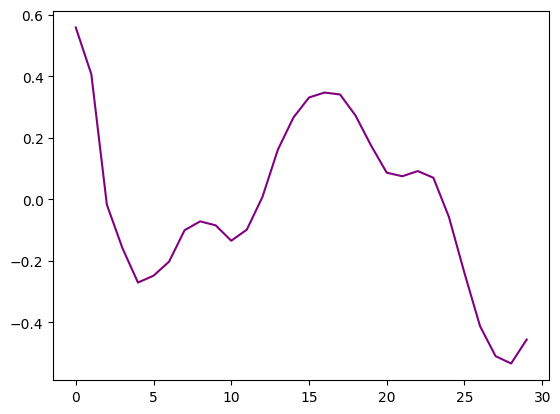

In [155]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(ba_list[:30], color='purple' )#i
plt.show()

In [122]:
len(torch.randint(1000, size=(10,)))

10

In [79]:
signal.filtfilt(b_l, a_l, std_x[0])[:1000]

array([ 3.03354507e-01,  2.98921902e-01,  2.94489796e-01,  2.90058367e-01,
        2.85627788e-01,  2.81198234e-01,  2.76769882e-01,  2.72342905e-01,
        2.67917479e-01,  2.63493779e-01,  2.59071980e-01,  2.54652255e-01,
        2.50234780e-01,  2.45819729e-01,  2.41407277e-01,  2.36997597e-01,
        2.32590863e-01,  2.28187249e-01,  2.23786929e-01,  2.19390075e-01,
        2.14996861e-01,  2.10607459e-01,  2.06222043e-01,  2.01840783e-01,
        1.97463853e-01,  1.93091423e-01,  1.88723666e-01,  1.84360752e-01,
        1.80002851e-01,  1.75650134e-01,  1.71302771e-01,  1.66960931e-01,
        1.62624784e-01,  1.58294498e-01,  1.53970241e-01,  1.49652181e-01,
        1.45340486e-01,  1.41035322e-01,  1.36736856e-01,  1.32445253e-01,
        1.28160680e-01,  1.23883301e-01,  1.19613280e-01,  1.15350781e-01,
        1.11095968e-01,  1.06849003e-01,  1.02610048e-01,  9.83792649e-02,
        9.41568145e-02,  8.99428570e-02,  8.57375521e-02,  8.15410588e-02,
        7.73535355e-02,  

In [47]:
torch.concat((te[:,3,:].unsqueeze(1), te[:,2,:].unsqueeze(1)), axis = 1).shape

torch.Size([995, 2, 300])

In [11]:
li  = list()
for i in range(10):
    li.append(te[i].tolist())

In [13]:
torch.tensor(li).shape

torch.Size([10, 3])

In [11]:
torch.std(te)

tensor(0.1381, dtype=torch.float64)

In [13]:
std_x = (te - torch.mean(te)) / torch.std(te)

In [20]:
torch.var(std_x[563])

tensor(0.1574, dtype=torch.float64)

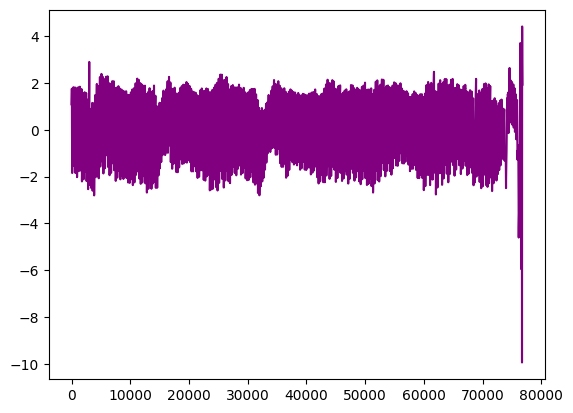

In [22]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(std_x[139,], color='purple' )#i

plt.show()

In [26]:
i = 205
from scipy import signal
import neurokit2 as nk
import numpy as np
b, a = signal.butter(8, 10 / 128, btype='low', analog=False)

sig = signal.filtfilt(b, a, std_x[i])
try:
    ppg_peaks_h = nk.ppg_findpeaks(sig, sampling_rate=256)
    ppg_peaks_l = nk.ppg_findpeaks(-1*sig, sampling_rate=256)
except:
    ppg_peaks_l = {'PPG_Peaks':np.array(range(128, 76800, 256))}
    ppg_peaks_h = {'PPG_Peaks':np.array(range(0, 76800, 256))}

ppg_peaks_l = ppg_peaks_l['PPG_Peaks']
ppg_peaks_h = ppg_peaks_h['PPG_Peaks']
dif = [sig[ppg_peaks_h[j]] - sig[ppg_peaks_l[j]]
       for j in range(min(len(ppg_peaks_h),len(ppg_peaks_l)))]
print(np.sum(dif > 2 * np.median(dif)),i)

12 205


In [28]:
import torch
torch.tensor(1)

tensor(1)

In [22]:
import os
files_in_temp = os.listdir('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test')
files_in_temp = [i[-7:-3] for i in files_in_temp]

In [27]:
import numpy as np
len(np.unique(files_in_temp))

350